Este codigo recopila información de diversas fuentes de datos, las homogeiniza y limpia, para luego buscar relaciones entre diversas variables.

El objetivo es encontrar explicaciones a la disparidad de resultados observados en un conjunto de distribuidores, en lo que respecta a la variación interanual en sus ventas. 

Para eso se emplean diversas técnicas: análisis descriptivos con gráficos, clústering, regresiones.

In [1]:
#Se improtan las librerías necesarias

#las típicas
import pandas as pd
import numpy as np
import datetime as DT

#Para construir mapas
import os
os.environ['PROJ_LIB'] = '/opt/conda/pkgs/proj4-5.2.0-he1b5a44_1003/share/proj'
from mpl_toolkits.basemap import Basemap

#Para georreferenciar
from geopy import Nominatim
import geocoder
import geopy.distance

#Para estimar clústers
from sklearn.cluster import KMeans
from sklearn import preprocessing

#Para realizar diversos tipos de gráficos
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

#Para modelos de regresión
import sklearn.linear_model 
from statsmodels.api import OLS

In [2]:
#Se accede a diversas fuentes de datos, en este caso son archivos .xlsx, pero también se utilizarán .csv y otras.
#Cada dataframe corresponde a tipos de venta y meses diferentes

mes1 = '\\Marzo'
mes2 = '\\marzo21'
path1 = r'C:' + mes1
path2 = r'C:' + mes2 
pedido_mes1 = pd.read_excel(path1 + '\Detalle de Pedidos.xlsx')
pedido_mes2 = pd.read_excel(path2 + '\Detalle de Pedidos.xlsx')
promo_mes1 = pd.read_excel(path1 + '\Promociones.xlsx')
promo_mes2 = pd.read_excel(path2 + '\Promociones.xlsx')
online_mes2 = pd.read_excel(path2 + '\Online.xlsx')

Transformación y limpieza

In [3]:
#Se eliminan filas innecesarias de los dataframes y se generan headers nuevos
new_header1 = pedido_mes1.iloc[6] #elegir la fila que tiene los títulos que corresponden
pedido_mes1= pedido_mes1[7:] #se toman los datos desde la fila que corresponda
pedido_mes1.columns = new_header1 #se definen los títulos como los headers antes definidos

new_header2 = pedido_mes2.iloc[6] 
pedido_mes2= pedido_mes2[7:] 
pedido_mes2.columns = new_header2 

new_header2 = promo_mes1.iloc[6] 
promo_mes1= promo_mes1[7:] 
promo_mes1.columns = new_header2 

new_header2 = promo_mes2.iloc[6] 
promo_mes2= promo_mes2[7:] 
promo_mes2.columns = new_header2 

new_header2 = online_mes2.iloc[4] 
online_mes2= online_mes2[6:] 
online_mes2.columns = new_header2 

In [4]:
#Se seleccionan los atributos necesarios de cada uno de los dataframes

pedido_mes1_corto = pedido_mes1[['Campaña', 'Id.AC', 'Precio', 'Cantidad',  
                                 'Dto, Prom,',  'idPersona', 'idP', 'zona']]
pedido_mes2_corto = pedido_mes2[['Campaña', 'Id.AC',   'Precio', 'Cantidad',  
                                'Dto. Prom.',  'idPersona', 'idP', 'zona']]
promo_mes1_corto = promo_mes1[['Campaña', 'Id AC',  'Precio Promocional', 'Cantidad Confirmada',  
                                 'Nombre de la Promocion',  'Id Persona',  'Zona']]
promo_mes2_corto = promo_mes2[['Campaña', 'Id AC',  'Precio Promocional', 'Cantidad Confirmada',  
                                 'Nombre de la Promoción',  'Id Persona',  'Zona']]
online_mes2_corto = online_mes2[['Campaña', 'AC',  'Total Pagado', 'Unidades',  'CodCP']]

In [5]:
#cambio de nombre de columna
pedido_mes1_corto= pedido_mes1_corto.rename(columns={'Dto, Prom,': 'Dto. Prom.'})

In [6]:
#Se elimina un grupo de productos que no sirven para el análisis en los dataframes de pedidos

pedido_mes1_corto = pedido_mes1_corto[pedido_mes1_corto['idP'] != 99]
pedido_mes2_corto = pedido_mes2_corto[pedido_mes2_corto['idP'] != 99]

In [7]:
#Se eliminan promociones que no sirven para el análisis

promo_mes1_corto = promo_mes1_corto[promo_mes1_corto['Nombre de la Promocion'] != 'INSERT']
promo_mes1_corto = promo_mes1_corto[promo_mes1_corto['Nombre de la Promocion'] != 'Promo exclusiva']
promo_mes1_corto = promo_mes1_corto[promo_mes1_corto['Nombre de la Promocion'] != 'Exclusivos - Cada 200 unidades']
promo_mes1_corto = promo_mes1_corto[promo_mes1_corto['Nombre de la Promocion'] != 'Tienda']

promo_mes2_corto = promo_mes2_corto[promo_mes2_corto['Nombre de la Promoción'] != 'Exclusivos - Cada 200 unidades']

In [8]:
#Se carga un .csv con un padrón detallado de clientes
#servirá para recuperar datos de clientes de diferentes puntos de distribución

path3 = r''

padron = pd.read_csv(path3 + '\padron.csv', sep=';', encoding='latin1')

In [9]:
#Se completan algunos datos faltantes en las ventas online a partir de información de clientes

idpersona=padron[['IdPersona', 'IdAc', 'CodCp']]
idpersona['concat'] = idpersona['IdAc'].astype(str) + '-' + idpersona['CodCp'].astype(str)

idpersona_concat=idpersona[['IdPersona', 'concat']]

online_mes2_corto['concat']=online_mes2_corto['AC'].astype(str)+"-"+online_mes2_corto['CodCP'].astype(str)

online_mes2_corto = pd.merge(online_mes2_corto, idpersona_concat, on='concat', how='left')

zona = pedido_mes2_corto[['Id.AC',  'zona']]
zona= zona.rename(columns={'Id.AC': 'AC'})
zona =  zona.drop_duplicates(subset='AC', keep='first')

online_mes2_corto = pd.merge(online_mes2_corto, zona, on='AC', how='left')

<ipython-input-9-139dbc5aaa0e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idpersona['concat'] = idpersona['IdAc'].astype(str) + '-' + idpersona['CodCp'].astype(str)
<ipython-input-9-139dbc5aaa0e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_mes2_corto['concat']=online_mes2_corto['AC'].astype(str)+"-"+online_mes2_corto['CodCP'].astype(str)


In [10]:
#Se homogeinizan nombres de columnas en los diversos archivos
promo_mes1_corto= promo_mes1_corto.rename(columns={'Id Persona': 'idPersona'})
promo_mes2_corto= promo_mes2_corto.rename(columns={'Id Persona': 'idPersona'})
online_mes2_corto= online_mes2_corto.rename(columns={'IdPersona': 'idPersona'})

In [11]:
#Se realizan correcciones respecto a números mal generados o con formato incorrecto
pedido_mes1_corto['Dto. Prom.'] = pedido_mes1_corto['Dto. Prom.'].str.replace(',','.')
pedido_mes1_corto['Dto. Prom.'] = pedido_mes1_corto['Dto. Prom.'].astype(float)

pedido_mes2_corto['Dto. Prom.'] = pedido_mes2_corto['Dto. Prom.'].str.replace(',','.')
pedido_mes2_corto['Dto. Prom.'] = pedido_mes2_corto['Dto. Prom.'].astype(float)

pedido_mes2_corto['Precio'] = pedido_mes2_corto['Precio'].str.replace(',','.')
pedido_mes2_corto['Precio'] = pedido_mes2_corto['Precio'].astype(float)

In [12]:
#Se crea una nueva variable que indique el precio neto de descuentos

pedido_mes1_corto['precio_neto'] = pedido_mes1_corto['Precio'] - pedido_mes1_corto['Dto. Prom.']
pedido_mes2_corto['precio_neto'] = pedido_mes2_corto['Precio'] - pedido_mes2_corto['Dto. Prom.']

In [13]:
#Se realizan correcciones en números en otro de los archivos

online_mes2_corto['Total Pagado'] = online_mes2_corto['Total Pagado'].str.replace(',','.')
online_mes2_corto['Total Pagado'] = online_mes2_corto['Total Pagado'].astype(float)

In [14]:
#Se estima un precio promedio de ventas online

online_mes2_corto['precio'] = online_mes2_corto['Total Pagado'] / online_mes2_corto['Unidades']

In [15]:
#Luego de las correcciones, Se seleccionan las columnas necesarias

pedido_mes1_corto = pedido_mes1_corto[['Campaña', 'Id.AC',  'Cantidad', 'precio_neto',  'idPersona', 'zona']]

pedido_mes2_corto = pedido_mes2_corto[['Campaña', 'Id.AC',  'Cantidad', 'precio_neto',  'idPersona', 'zona']]

promo_mes1_corto = promo_mes1_corto[['Campaña', 'Id AC',  'Cantidad Confirmada', 'Precio Promocional',  'idPersona',  'Zona']]

promo_mes2_corto = promo_mes2_corto[['Campaña', 'Id AC',  'Cantidad Confirmada', 'Precio Promocional',  'idPersona',  'Zona']]

online_mes2_corto = online_mes2_corto[['Campaña', 'AC', 'Unidades',  'precio',  'idPersona', 'zona']]

In [16]:
#Se homogeinizan las restantes columnas

promo_mes1_corto= promo_mes1_corto.rename(columns={'Id AC': 'Id.AC', 'Cantidad Confirmada': 'Cantidad',
                                                 'Precio Promocional': 'precio_neto', 'Zona': 'zona'})

promo_mes2_corto= promo_mes2_corto.rename(columns={'Id AC': 'Id.AC', 'Cantidad Confirmada': 'Cantidad',
                                                 'Precio Promocional': 'precio_neto', 'Zona': 'zona'})

online_mes2_corto= online_mes2_corto.rename(columns={'AC': 'Id.AC', 'Unidades': 'Cantidad',
                                                 'precio': 'precio_neto'})

In [17]:
#Se agrega una columna en cada dataframe que indique el tipo de venta

pedido_mes1_corto['tipo'] = 'pedido'
pedido_mes2_corto['tipo'] = 'pedido'

promo_mes1_corto['tipo'] = 'promo'
promo_mes2_corto['tipo'] = 'promo'

online_mes2_corto['tipo'] = 'flip'

In [18]:
#Control de totales

print (pedido_mes1_corto['Cantidad'].sum(), promo_mes1_corto['Cantidad'].sum())

print (pedido_mes2_corto['Cantidad'].sum(), promo_mes2_corto['Cantidad'].sum(), online_mes2_corto['Cantidad'].sum())

106711 766
100774 5372 1952


In [19]:
#Se controlan totales de algunos puntos de distribución
pedido_mes1_corto_prueba = pedido_mes1_corto[pedido_mes1_corto['Id.AC'] == 8540]
pedido_mes1_corto_prueba2 = pedido_mes1_corto[pedido_mes1_corto['Id.AC'] == 8960]
print (pedido_mes1_corto_prueba['Cantidad'].sum())
print (pedido_mes1_corto_prueba2['Cantidad'].sum())

pedido_mes2_corto_prueba = pedido_mes2_corto[pedido_mes2_corto['Id.AC'] == 8540]
pedido_mes2_corto_prueba2 = pedido_mes2_corto[pedido_mes2_corto['Id.AC'] == 8960]
print (pedido_mes2_corto_prueba['Cantidad'].sum())
print (pedido_mes2_corto_prueba2['Cantidad'].sum())

319
0
0
759


In [20]:
#Se unen todos los tipos de venta en dos dataframes, uno por cada mes de análisis

mes_1 = [pedido_mes1_corto, promo_mes1_corto]
mes_2 = [pedido_mes2_corto, promo_mes2_corto, online_mes2_corto]
mes_1 = pd.concat(mes_1, sort=False)
mes_2 = pd.concat(mes_2, sort=False)

In [21]:
#Se genera un total de ventas para cada mes por cliente

mes_1_por_CP = pd.pivot_table(mes_1, 
                              values=['Cantidad'], 
                              index=['idPersona'],
                              aggfunc=('sum')).fillna(0)


mes_2_por_CP = pd.pivot_table(mes_2, 
                              values=['Cantidad'], 
                              index=['idPersona'],
                              aggfunc=('sum')).fillna(0)

In [22]:
#Se cruzan los dataframes anteriores con los datos de los clientes 

mes_1_datos = mes_1[['Id.AC', 'idPersona', 'zona']]
mes_2_datos = mes_2[['Id.AC', 'idPersona', 'zona']]

mes_1_datos =  mes_1_datos.drop_duplicates(subset='idPersona', keep='first')
mes_2_datos =  mes_2_datos.drop_duplicates(subset='idPersona', keep='first')

mes_1_por_CP = pd.merge(mes_1_por_CP, mes_1_datos, on='idPersona', how='left')
mes_2_por_CP = pd.merge(mes_2_por_CP, mes_2_datos, on='idPersona', how='left')

In [23]:
#Se unifican las cantidades por cliente, ya con datos, de los dos meses en un solo dataframe

dos_meses = pd.merge(mes_1_por_CP, mes_2_por_CP, on='idPersona', how = 'outer')

In [24]:
#Se limpia y homogeiniza el dataframe de cantidades por cliente para los dos meses
dos_meses_corto = dos_meses[['idPersona', 'Id.AC_x', 'Id.AC_y', 
                             'Cantidad_x', 'Cantidad_y', 
                             'zona_y']]

dos_meses_corto= dos_meses_corto.rename(columns={'Id.AC_x': 'Id.AC_mar_20', 'Id.AC_y': 'Id.AC_mar_21',
                                                 'Cantidad_x': 'Cantidad_mar_20', 'Cantidad_y': 'Cantidad_mar_21',
                                                 'zona_y': 'zona_AC_mar_21'})
dos_meses_corto = dos_meses_corto.fillna(0)

In [25]:
#Es necesario un archivo clave/valor que sirve para unificar a diversos distribuidores en entidades únicas
path4 = r'C:'

AC_sup = pd.read_excel(path4 + '\AC sup.xlsx')

In [26]:
#Se cruza el ID de los distribuidores de ambos meses con los ID superiores, para formar entidades unificadas

dos_meses_corto= pd.merge(dos_meses_corto, AC_sup, left_on='Id.AC_mar_20', right_on = 'ID_AC', how='left')
dos_meses_corto= pd.merge(dos_meses_corto, AC_sup, left_on='Id.AC_mar_21', right_on = 'ID_AC', how='left')

In [27]:
#Algunas correcciones

dos_meses_corto= dos_meses_corto.rename(columns={'AC_sup_x': 'AC_sup_mar_20', 'AC_sup_y': 'AC_sup_mar_21'})
dos_meses_corto = dos_meses_corto.drop(['ID_AC_x', 'ID_AC_y'], axis=1)

In [29]:
#El dataframe con información por cliente, teniendo en cuenta cuanto compró en cada mes y a qué distribuidor
dos_meses_corto.head()

,idPersona,Id.AC_mar_20,Id.AC_mar_21,Cantidad_mar_20,Cantidad_mar_21,zona_AC_mar_21,AC_sup_mar_20,AC_sup_mar_21
0,1,8190,0,3.0,0.0,0,50,NaN
1,5,50,50,13.0,24.0,2,50,50
2,8,80,80,1.0,1.0,1,80,80
3,33,280,8930,5.0,14.0,1,280,280
4,35,380,380,5.0,40.0,2,380,380


In [30]:
#Se seleccionan  con las columnas útiles del padrón de clientes

padron_corto = padron[['IdPersona', 'IdAc', 'CodLider', 'FechaNac', 'FechaAlta', 'Documento', 'FecInicioVend', 'UltimoProcesadoCampana', 'Localidad', 'Provincia']]

In [31]:
padron_corto= padron_corto.rename(columns={'IdPersona': 'idPersona'})

In [32]:
#Se cruza la información de los clientes con el dataframe de cantidades por cliente de los dos meses

dos_meses_corto = pd.merge(dos_meses_corto, padron_corto, on='idPersona', how = 'left')

In [33]:
#Se realizan correcciones en los nombres de las localidades y provincias de los clientes

dos_meses_corto['Provincia'] = dos_meses_corto['Provincia'].replace('BENI', '0')
dos_meses_corto['Provincia'] = dos_meses_corto['Provincia'].fillna('0')
dos_meses_corto['Localidad'] = dos_meses_corto['Localidad'].fillna('0')
dos_meses_corto['Localidad'] = dos_meses_corto['Localidad'].str.replace('(PROV. LA PAMPA)', '')
dos_meses_corto['Localidad'] = dos_meses_corto['Localidad'].str.replace('(PROV. JUJUY)', '')
dos_meses_corto['Localidad'] = dos_meses_corto['Localidad'].str.replace('(PROV. CORDOBA)','')
dos_meses_corto['Localidad'] = dos_meses_corto['Localidad'].str.replace('(PROV. RIO NEGRO)', '')
dos_meses_corto['Localidad'] = dos_meses_corto['Localidad'].str.replace('(PROV. TIERRA DEL FUEGO)', '')
dos_meses_corto['Localidad'] = dos_meses_corto['Localidad'].str.replace('(PROV. TUCUMAN)','')
dos_meses_corto['Localidad'] = dos_meses_corto['Localidad'].str.replace('(PROV. MISIONES)', '')
dos_meses_corto['Localidad'] = dos_meses_corto['Localidad'].str.replace('(PROV. SALTA)',  '')
dos_meses_corto['Localidad'] = dos_meses_corto['Localidad'].str.replace('(PROV. CORRIENTES)', '')
dos_meses_corto['Localidad'] = dos_meses_corto['Localidad'].str.replace('()', '')
dos_meses_corto['Localidad'] = dos_meses_corto['Localidad'].str.replace(' COOP', '')  
dos_meses_corto['Localidad'] = dos_meses_corto['Localidad'].str.replace('CAPITAL FEDERAL Y ALREDEDORES', 'CABA') 

In [34]:
#Se generan totales de ventas por distribuidores para cada mes

por_AC_Sup_mar_20 = pd.pivot_table(dos_meses_corto, 
                        values=['Cantidad_mar_20'], 
                        index=['AC_sup_mar_20'],
                        aggfunc=('sum')).fillna(0)


por_AC_Sup_mar_21 = pd.pivot_table(dos_meses_corto, 
                        values=['Cantidad_mar_21'], 
                        index=['AC_sup_mar_21'],
                        aggfunc=('sum')).fillna(0)

In [35]:
por_AC_Sup_mar_20 = por_AC_Sup_mar_20.reset_index()
por_AC_Sup_mar_21 = por_AC_Sup_mar_21.reset_index()

In [36]:
por_AC_Sup_mar_20= por_AC_Sup_mar_20.rename(columns={'AC_sup_mar_20': 'AC_sup'})
por_AC_Sup_mar_21= por_AC_Sup_mar_21.rename(columns={'AC_sup_mar_21': 'AC_sup'})

In [37]:
#Se une la información de cantidades de ventas por distribuidor para los dos meses

por_AC_Sup = pd.merge(por_AC_Sup_mar_20, por_AC_Sup_mar_21, on='AC_sup', how='left')

In [38]:
#Se calculan las variaciones interanuales de cada distribuidor, medida de desempeño

por_AC_Sup['variación'] = por_AC_Sup['Cantidad_mar_21']/por_AC_Sup['Cantidad_mar_20']-1

In [39]:
#Con el listado de clientes para los dos meses Se crean dos dataframe 
#considerando aquellos clientes que tienen alguna compra en cada mes

dos_meses_corto_SIN0_20 = dos_meses_corto[dos_meses_corto['Cantidad_mar_20'] > 0]
dos_meses_corto_SIN0_21 = dos_meses_corto[dos_meses_corto['Cantidad_mar_21'] > 0]

In [40]:
#Se hace un conteo diferenciado de los Id de los clientes en cada mes para los diferentes distribuidores unificados
CPs_ACsup_mar_20 = pd.pivot_table(dos_meses_corto_SIN0_20, 
                                  values=['idPersona'],
                                  index=['AC_sup_mar_20'],
                                  aggfunc=(lambda x: len(x.unique()))).fillna(0)


CPs_ACsup_mar_21 = pd.pivot_table(dos_meses_corto_SIN0_21, 
                                  values=['idPersona'], 
                                  index=['AC_sup_mar_21'],
                                  aggfunc=(lambda x: len(x.unique()))).fillna(0)

In [41]:
CPs_ACsup_mar_20 = CPs_ACsup_mar_20.reset_index()
CPs_ACsup_mar_21 = CPs_ACsup_mar_21.reset_index()

In [42]:
CPs_ACsup_mar_20= CPs_ACsup_mar_20.rename(columns={'idPersona': 'CPs_mar_20'})
CPs_ACsup_mar_21= CPs_ACsup_mar_21.rename(columns={'idPersona': 'CPs_mar_21'})

In [43]:
CPs_ACsup_mar_20= CPs_ACsup_mar_20.rename(columns={'AC_sup_mar_20': 'AC_sup'})
CPs_ACsup_mar_21= CPs_ACsup_mar_21.rename(columns={'AC_sup_mar_21': 'AC_sup'})

In [44]:
#Se une la cantidad de clientes de cada mes con el dataframe de cantidades pedidas por distribuidor

por_AC_Sup = pd.merge(por_AC_Sup, CPs_ACsup_mar_20, on='AC_sup', how='left')
por_AC_Sup = pd.merge(por_AC_Sup, CPs_ACsup_mar_21, on='AC_sup', how='left')

In [46]:
#Se calcula el promedio de compra por cliente de cada distribuidor unificado

por_AC_Sup['promedio_mar_21'] = por_AC_Sup['Cantidad_mar_21'] / por_AC_Sup['CPs_mar_21']

In [47]:
#Revisar las variables de un distribuidor puntual
por_AC_Sup[por_AC_Sup['AC_sup'] == 5610]

,AC_sup,Cantidad_mar_20,Cantidad_mar_21,variación,CPs_mar_20,CPs_mar_21,promedio_mar_21
77,5610,1370.0,1991.0,0.453285,112,157.0,12.681529


In [48]:
#Con el detalle de ventas por cliente, se genera una variable llamada "ciudad" y luego una lista con dichas ciudades

dos_meses_corto['Ciudad'] = dos_meses_corto['Localidad'] + ', ' + dos_meses_corto['Provincia'] + ', Argentina'

ciudades = dos_meses_corto['Ciudad'].unique().tolist()

In [49]:
# Se utiliza un ARCHIVO COMPLEMENTARIO DE LATITUD Y LONGITUD POR CIUDADES previamente completado
#(esto permite ganar tiempo de búsqueda para la georreferenciación de los clientes)

path5 = r'C'

lat_long = pd.read_excel(path5 + '\lat y long por localidad argentina.xlsx')

lat_long = lat_long.rename(columns={'ciudad': 'Ciudad', ' Lon': 'longitud', 'Lat': 'latitud'})
lat_long = lat_long[['Ciudad', 'latitud', 'longitud']]

In [50]:
#Se realiza el primer cruce con las ciudades que ya registradas
dos_meses_corto= pd.merge(dos_meses_corto, lat_long, on='Ciudad', how='left').fillna(0)

In [51]:
#Se buscan missings (ciudades que no estén en el listado)
#se genera una lista con las ciudades que no están identificadas con sus coordenadas
datos_lat_lon_miss = dos_meses_corto[['Ciudad', 'latitud', 'longitud']]
datos_lat_lon_miss = datos_lat_lon_miss.loc[datos_lat_lon_miss['latitud'] == 0]
datos_lat_lon_miss = datos_lat_lon_miss.loc[datos_lat_lon_miss['Ciudad'] != '0, 0, Argentina']
ciudades_sinLatLon = datos_lat_lon_miss['Ciudad'].unique()
ciudades_sinLatLon_list = datos_lat_lon_miss['Ciudad'].unique().tolist()

In [52]:
#Se buscan las coordenadas de aquellas ciudades no identificadas en el listado guardado

latitudes =[]
longitudes = []

geolocator = Nominatim(user_agent="https://xxxxxxxx.com/")

for line in range(len(ciudades_sinLatLon_list)):
    location_c = geolocator.geocode(ciudades_sinLatLon_list[line], timeout=100)
       
    if location_c is None:
        latitudes.append(0)
        longitudes.append(0)
    else:
        latitudes.append(location_c.latitude)
        longitudes.append(location_c.longitude)
    

ciudades_CPs = pd.DataFrame({'Ciudad':ciudades_sinLatLon_list, 'latitud': latitudes, 'longitud': longitudes})  

In [53]:
#Se limpia de la lista aquellas ciudades de las que no se encontró información
ciudades_CPs = ciudades_CPs[ciudades_CPs['latitud'] != 0]

In [54]:
#se unen las nuevas localidades al dataframe original de lat y long
frames_LatLon = [lat_long, ciudades_CPs]
lat_lon_nuevo = pd.concat(frames_LatLon, sort=False)

In [55]:
#Se eliminan las lat y long anteriores del dataframe de clientes y se vuelve a cruzar 

dos_meses_corto = dos_meses_corto.drop(['latitud', 'longitud'], axis=1)
dos_meses_corto= pd.merge(dos_meses_corto, lat_lon_nuevo, on='Ciudad', how='left').fillna(0)

In [56]:
#Para conocer las ubicaciones aproximadas de las redes de clientes de los distribuidores se estiman LAS MEDIANAS DE LAS REDES

lat_lon_CPs_AC = dos_meses_corto[['AC_sup_mar_21', 'latitud', 'longitud']]

lat_lon_CPs_AC = lat_lon_CPs_AC[lat_lon_CPs_AC['latitud'] < -0.0001]

lat_lon_median_AC= pd.pivot_table(lat_lon_CPs_AC, values=['latitud', 'longitud'], 
                                  index=['AC_sup_mar_21'], 
                                  aggfunc='median').fillna(0)

lat_lon_median_AC = lat_lon_median_AC.reset_index()
lat_lon_median_AC.columns = ['AC_sup_mar_21', 'latitud_mediana', 'longitud_mediana']
lat_lon_median_AC= lat_lon_median_AC.rename(columns={'AC_sup_mar_21': 'AC_sup'})

In [57]:
#Se agregan las coordenadas medianas al dataframe de información por distribuidor

por_AC_Sup_region = pd.merge(por_AC_Sup, lat_lon_median_AC, on='AC_sup', how='left')

In [58]:
#Revisar la información de un distribuidor

por_AC_Sup_region[por_AC_Sup_region['AC_sup'] == 5610]

,AC_sup,Cantidad_mar_20,Cantidad_mar_21,variación,CPs_mar_20,CPs_mar_21,promedio_mar_21,latitud_mediana,longitud_mediana
77,5610,1370.0,1991.0,0.453285,112,157.0,12.681529,-27.805321,-64.261223


In [59]:
#Se leen otros archivos con información de desempeño pasado de los distribuidores, 
#cantidad de nuevos clientes, exclusividad, tipos de clientes, zonas de influencia 
#y nombres de fantasia de los distribuidores

path6 = r'C:'

verano_porAC = pd.read_excel(path6 + '\\var IA verano 2021 por AC.xlsx')
altas_porAC = pd.read_excel(path6 + '\\altas por Ac verano 2021.xlsx')
excl_AC = pd.read_excel(path6 + '\\exclusividad ACs.xlsx')
comport_CP_por_AC = pd.read_excel(path6 + '\\comportamiento CP por AC.xlsx')
zonas = pd.read_excel(path6 + '\\zonas.xlsx')
nombre_AC = pd.read_excel(path6 + '\\nombres AC.xlsx')


In [60]:
#se extraen 4 caracteres del nombre de los distribuidores

nombre_AC['nombre'] = nombre_AC['Nombre AC'].str[:4]

In [61]:
nombre_AC = nombre_AC[['Id AC', 'nombre']]
nombre_AC= nombre_AC.rename(columns={'Id AC': 'AC_sup'})

In [62]:
#Se cruza el dataframe de información por distribuidor con los atributos

por_AC_Sup_region = pd.merge(por_AC_Sup_region,verano_porAC,on='AC_sup', how='left')
por_AC_Sup_region = pd.merge(por_AC_Sup_region,altas_porAC,on='AC_sup', how='left')
por_AC_Sup_region = pd.merge(por_AC_Sup_region,zonas,on='AC_sup', how='left')
por_AC_Sup_region = pd.merge(por_AC_Sup_region,nombre_AC,on='AC_sup',how='left')

In [63]:
#Se realiza una limpieza de ciertos valores no deseables en el dataframe

por_AC_Sup_region = por_AC_Sup_region[por_AC_Sup_region['variación'].notna()]
por_AC_Sup_region = por_AC_Sup_region[por_AC_Sup_region['AC_sup'].notna()]
por_AC_Sup_region = por_AC_Sup_region[por_AC_Sup_region['AC_sup'] != 570]
por_AC_Sup_region = por_AC_Sup_region[por_AC_Sup_region['AC_sup'] != 1630]

In [64]:
por_AC_Sup_region = por_AC_Sup_region.reset_index()

por_AC_Sup_region =  por_AC_Sup_region.drop(['index'], axis=1)

EL PRIMER PASO ANALÍTICO ES CONSTRUIR CLUSTERS CON ALGUNAS VARIABLES DE LOS DISTRIBUIDORES

In [66]:
por_AC_sup_clusterizar = por_AC_Sup_region[['AC_sup', 'Cantidad_mar_21', 'variación', 'promedio_mar_21', 
                                            'latitud_mediana','longitud_mediana', 'var verano', 'altas', 'Zona', 'nombre']]

In [67]:
#se seleccionan las variables útiles para clusterizar
por_AC_sup_clusterizar_SinCoor = por_AC_sup_clusterizar[['AC_sup', 'Cantidad_mar_21', 'variación', 'promedio_mar_21', 
                                                               'var verano', 'altas', 'Zona', 'nombre']]

In [68]:
#se genera el dataframe para clusterizar, el que debe ser estandarizado para suprimir las diferentes escalas entre variables

x = por_AC_sup_clusterizar_SinCoor.iloc[:,1:-2]

x_estan = preprocessing.scale(x)

pd.set_option('display.max_rows', 500)

x_estan = pd.DataFrame(x_estan)
x_estan.columns = x.columns

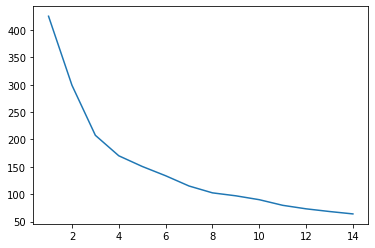

In [69]:
#Se trata de establecer la cantidad de clusters, para esto se utiliza el parámetro wcss, 
#cuando se vuelve asintótico es un buen número de clústers
#en este caso, no converge, pero se utilizan, por conveniencia, 5 clústers

#desactivar la interactividad del gráfico
%matplotlib inline 

#estimar wcss
wcss_todas_estan=[]

for i in range(1,15):
    kmeans_todas_estan=KMeans(i)
    kmeans_todas_estan.fit(x_estan)
    wcss_iter_todas_estan = kmeans_todas_estan.inertia_
    wcss_todas_estan.append(wcss_iter_todas_estan)

numero_clusters = range(1,15)

plt.plot(numero_clusters, wcss_todas_estan)

plt.show()

In [70]:
#se estiman 5 clústers, y se genera la variable clúster en el dataframe
kmeans=KMeans(5)
kmeans.fit(x_estan)
clusters = kmeans.fit_predict(x_estan)
por_AC_sup_cluster_SinCoor = por_AC_sup_clusterizar_SinCoor.copy()
por_AC_sup_cluster_SinCoor['Cluster'] = clusters

EL SIGUIENTE PASO ES EL ANÁLISIS GRÁFICO

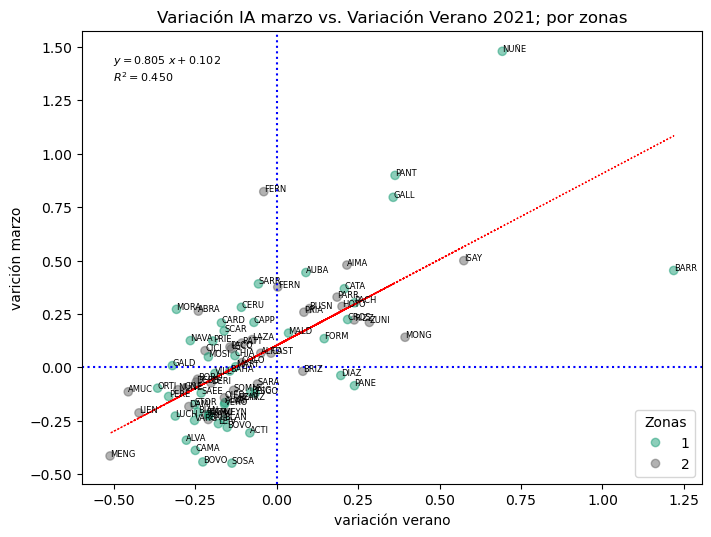

In [72]:
#Se genera un gráfico que muestra la relación entre el desempeño pasado y el actual de cada distribuidor, 
#agrupado por zona de influencia, además, se agregan la relación lineal y puntos de quiebre horizontal y vertical

#opción interactiva
#matplotlib notebook
%matplotlib inline 

x = por_AC_Sup_region['var verano']
y = por_AC_Sup_region['variación']
zona = por_AC_Sup_region['Zona']
nombres = por_AC_Sup_region['nombre']

figure(figsize=(8, 6), dpi=100)
scatter = plt.scatter(x, y, c=zona, cmap = 'Dark2',alpha=0.5) #gráfico
plt.axhline(y=0, color='b', linestyle=':') #línea fija horizontal
plt.axvline(x=0, color='b', linestyle=':') #línea fija vertical

#Línea de tendencia
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)
plt.plot(x, y_hat, "r:", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=8, verticalalignment='top')


plt.title('Variación IA marzo vs. Variación Verano 2021; por zonas')
plt.xlabel('variación verano')
plt.ylabel('varición marzo')

#leyenda por separación de color
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower right", title="Zonas")

#etiqueta en cada punto
for i, txt in enumerate(nombres):
    plt.annotate(txt, (x[i], y[i]), fontsize=6)

plt.show()

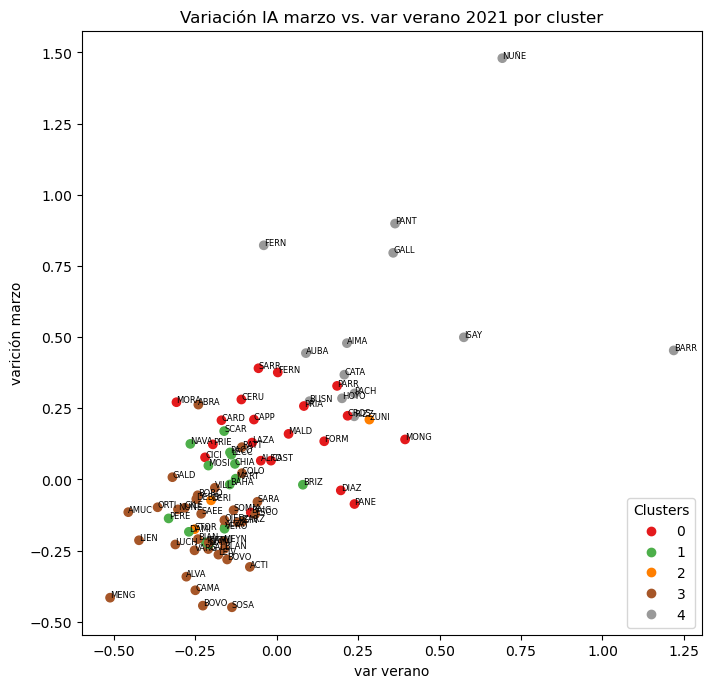

In [74]:
#Relación entre desempeños, agrupados por clústers

x = por_AC_sup_cluster_SinCoor['var verano']
y = por_AC_sup_cluster_SinCoor['variación']
cluster = por_AC_sup_cluster_SinCoor['Cluster']
nombres = por_AC_sup_cluster_SinCoor['nombre']

plt.figure(figsize=(8, 8), dpi=100)

scatter = plt.scatter(x, y,c=cluster,  cmap = 'Set1')

# leyenda por colores
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower right", title="Clusters")

for i, txt in enumerate(nombres):
    plt.annotate(txt, (x[i], y[i]), fontsize=6)

plt.title('Variación IA marzo vs. var verano 2021 por cluster')
plt.xlabel('var verano')
plt.ylabel('varición marzo')
plt.show()

<IPython.core.display.Javascript object>


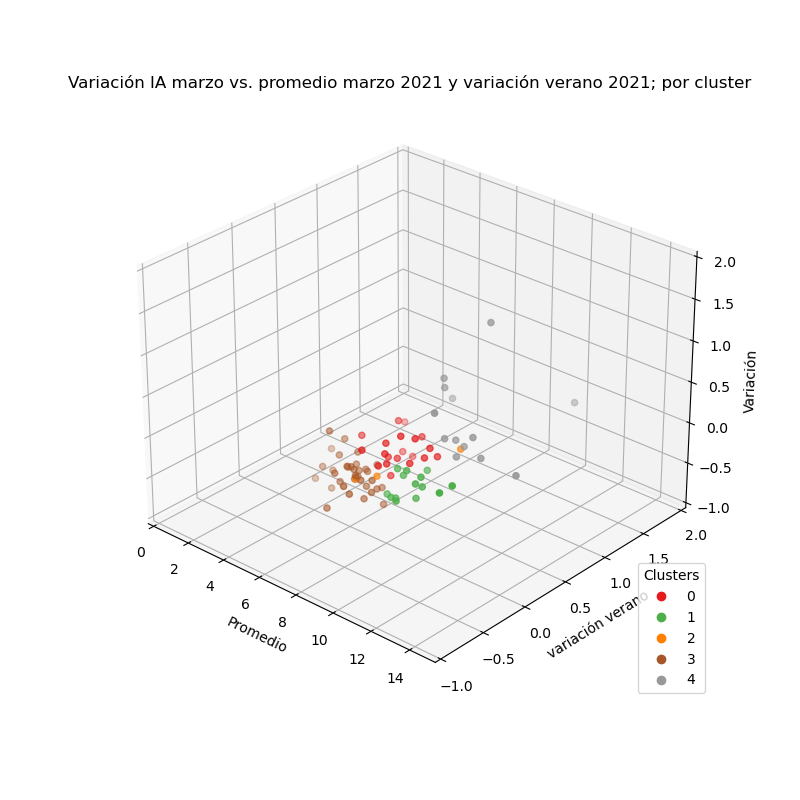

In [75]:
#Gráfico tridimensional entre desempeño pasado, presente y el promedio de venta de cada distribuidor

%matplotlib notebook

# Se crea la figura
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')

# se generan las listas de valores
x = por_AC_sup_cluster_SinCoor['promedio_mar_21']
y = por_AC_sup_cluster_SinCoor['var verano']
z = por_AC_sup_cluster_SinCoor['variación']
cluster = por_AC_sup_cluster_SinCoor['Cluster']

# gráfico
scatter = ax.scatter(x, y, z, c=cluster, cmap = 'Set1')

#características del gráfico
ax.set_xlim(0,15)
ax.set_ylim(-1, 2)
ax.set_zlim(-1, 2)
ax.set_xlabel('Promedio')
ax.set_ylabel('variación verano')
ax.set_zlabel('Variación')
plt.title('Variación IA marzo vs. promedio marzo 2021 y variación verano 2021; por cluster')

# leyenda por colores
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Clusters")

# rotación de los ejes
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

PARA FORMACIZAR LA RELACIÓN EXISTENTE ENTRE LAS VARIABLES EXPLICATIVAS Y LA EXPLICADA, SE RECURRE A UNA REGRESIÓN LINEAL MÚLTIPLE

In [76]:
X_regre = por_AC_sup_cluster_SinCoor[[ 'promedio_mar_21','var verano',]]
Y_regre = por_AC_sup_cluster_SinCoor[['variación']]

In [77]:
OLS(Y_regre,X_regre).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              variación   R-squared (uncentered):                   0.485
Model:                            OLS   Adj. R-squared (uncentered):              0.473
Method:                 Least Squares   F-statistic:                              39.09
Date:                Wed, 14 Apr 2021   Prob (F-statistic):                    1.09e-12
Time:                        16:01:22   Log-Likelihood:                          4.8655
No. Observations:                  85   AIC:                                     -5.731
Df Residuals:                      83   BIC:                                    -0.8456
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
promedio_mar_21     0.0125      0.003      4.375      0.000       0.007       0.018
var verano          0.7730      0.094      8.243      0.000       0.587       0.960
==============================================================================
Omnibus:                       16.036   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.173
Skew:                           0.767   Prob(JB):                     3.42e-06
Kurtosis:                       5.181   Cond. No.                         33.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

LUEGO DE COMPROBAR QUE EL PROMEDIO DE COMPRA POR CLIENTE Y EL DESEMPEÑO PASADO EXPLICAN LAS DIFERENCIAS PRESENTES, SE BUSCA ALGUNA EXPLICACIÓN ADICIONAL EN LA GEOGRAFÍA

In [78]:
#Se genera un atributo "creció" según la variación interanual de cada distribuidor sea positiva o negativa
variación = por_AC_sup_clusterizar['variación'].tolist()
crecio = []

for i in range(len(variación)):
    if variación[i] > 0:
        crecio.append(1)
    else:
        crecio.append(0)
        
por_AC_sup_clusterizar['crecio'] = crecio

<ipython-input-78-377634f4454f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  por_AC_sup_clusterizar['crecio'] = crecio


In [79]:
#Se genera el valor absoluto de la variación interanual de cada distribuidor
variación = por_AC_sup_clusterizar['variación'].tolist()
var_abs = []

for i in range(len(variación)):
    if variación[i] > 0:
        var_abs.append(variación[i])
    else:
        var_abs.append(variación[i]*-1)
        
por_AC_sup_clusterizar['var_abs'] = var_abs

<ipython-input-79-eae075698821>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  por_AC_sup_clusterizar['var_abs'] = var_abs


<IPython.core.display.Javascript object>


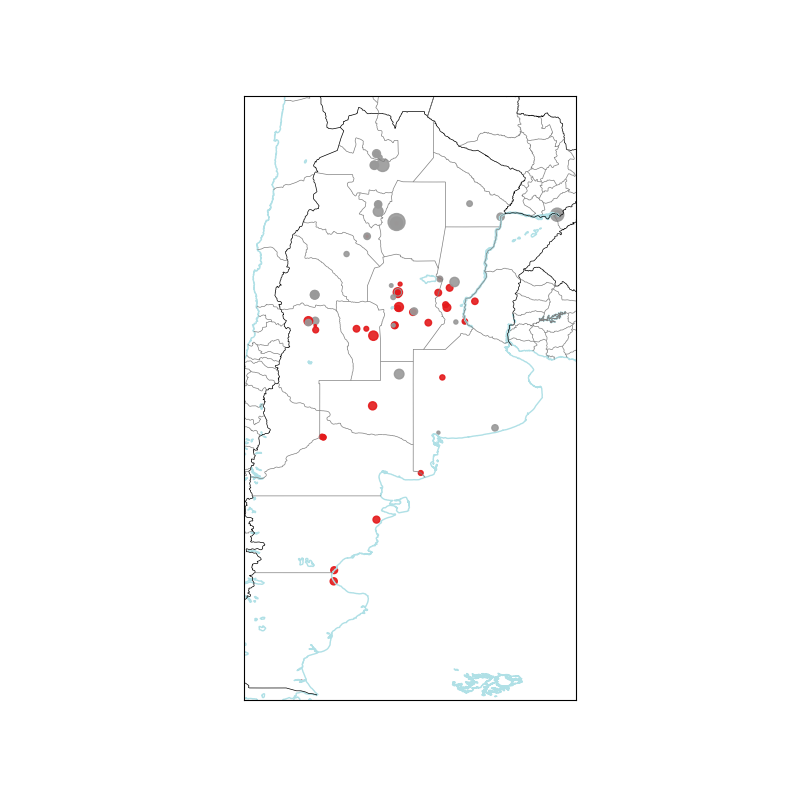

In [80]:
#Se grafica el desempeño de cada distribuidor en un mapa según el comportamiento y la magnitud de la variación

#Valores a tener en cuenta
lats_A = por_AC_sup_clusterizar['latitud_mediana']
lons_A = por_AC_sup_clusterizar['longitud_mediana']
var = por_AC_sup_clusterizar['var_abs']
crecio = por_AC_sup_clusterizar['crecio']

#límites del mapa
min_lon = lons_A.min()-3
min_lat = lats_A.min()-1
max_lon = lons_A.max()+1
max_lat = lats_A.max()+3

#definición del mapa
fig = plt.figure(figsize=(8, 8), dpi=100)
m = Basemap(projection='cyl', resolution='h', 
            llcrnrlon= min_lon, 
            llcrnrlat = min_lat, 
            urcrnrlon = max_lon, 
            urcrnrlat=max_lat
           )
            
m.drawcoastlines(color='powderblue')
m.drawcountries(color='black')
m.drawstates(color='grey')

# graficar coordenada del distribuidor sobre el mapa
m.scatter(lons_A, lats_A, latlon=True, s=var*100, c = crecio, cmap= 'Set1', alpha=0.9) #clientes


SE REESTIMA EL MODELO INCLUYENDO LA LATITUD COMO VARIABLE EXPLICATIVA, LA QUE PARECE TENER UN EFECTO EN LAS VENTAS



In [81]:
X_regre = por_AC_sup_clusterizar[[ 'promedio_mar_21','var verano','latitud_mediana']]
Y_regre = por_AC_sup_clusterizar[['variación']]

In [82]:
OLS(Y_regre,X_regre).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              variación   R-squared (uncentered):                   0.535
Model:                            OLS   Adj. R-squared (uncentered):              0.518
Method:                 Least Squares   F-statistic:                              31.51
Date:                Wed, 14 Apr 2021   Prob (F-statistic):                    1.20e-13
Time:                        16:04:20   Log-Likelihood:                          9.2492
No. Observations:                  85   AIC:                                     -12.50
Df Residuals:                      82   BIC:                                     -5.171
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
promedio_mar_21     0.0460      0.012      3.987      0.000       0.023       0.069
var verano          0.5808      0.110      5.262      0.000       0.361       0.800
latitud_mediana     0.0097      0.003      2.985      0.004       0.003       0.016
==============================================================================
Omnibus:                       20.889   Durbin-Watson:                   2.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.475
Skew:                           0.935   Prob(JB):                     7.28e-09
Kurtosis:                       5.662   Cond. No.                         155.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

LUEGO DE ENCONTRAR TRES VARIABLES RELEVANTES EN EL DESEMPEÑO ACTUAL DE LOS DISTRIBUIDORES, ES IMPORTANTE TRATAR DE BUSCAR EXPLICACIONES DE RESULTADO PASADO, PARA ELLOS NOS VALDREMOS DE LA PROPORCIÓN DE CLIENTES NUEVOS O ANTIGUOS QUE TENGAN LOS DISTRIBUIDORES

In [83]:
#Se incorpora el % de clientes de diferentes comportamientos que tienen los distribuidores
por_AC_Sup_region_comp_CP = pd.merge(por_AC_Sup_region, comport_CP_por_AC, on='AC_sup', how='left')

In [84]:
#Se elimina un distribuidos con un comportamineto atípico
por_AC_Sup_region_comp_CP_sin8960 = por_AC_Sup_region_comp_CP[por_AC_Sup_region_comp_CP['AC_sup'] !=8960]

In [85]:
X_regre = por_AC_Sup_region_comp_CP_sin8960[[
    '%_VER_alta',
   '%_VER_cont larga', 
    ]]

Y_regre = por_AC_Sup_region_comp_CP_sin8960[['var verano']]

In [86]:
OLS(Y_regre,X_regre).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             var verano   R-squared (uncentered):                   0.186
Model:                            OLS   Adj. R-squared (uncentered):              0.167
Method:                 Least Squares   F-statistic:                              9.393
Date:                Wed, 14 Apr 2021   Prob (F-statistic):                    0.000212
Time:                        16:06:23   Log-Likelihood:                          2.2177
No. Observations:                  84   AIC:                                    -0.4355
Df Residuals:                      82   BIC:                                      4.426
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
%_VER_alta           0.4895      0.203      2.415      0.018       0.086       0.893
%_VER_cont larga    -0.2591      0.062     -4.195      0.000      -0.382      -0.136
==============================================================================
Omnibus:                       41.872   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.741
Skew:                           1.615   Prob(JB):                     1.50e-29
Kurtosis:                       8.244   Cond. No.                         5.21
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

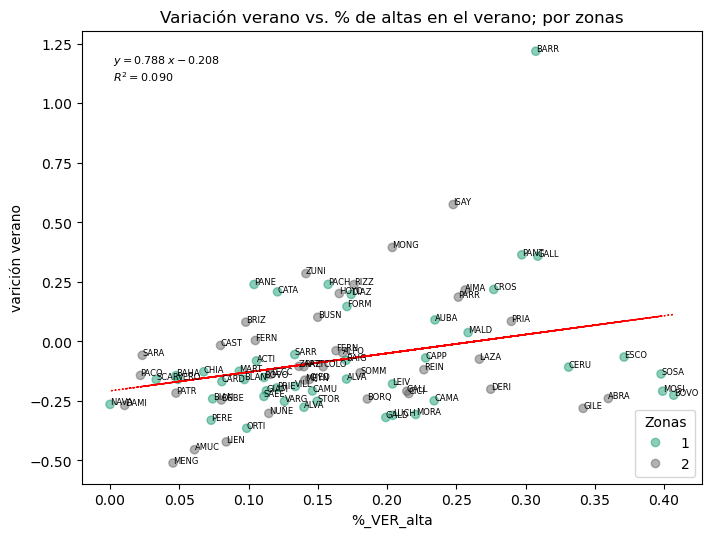

In [88]:
# opción interactiva
#%matplotlib notebook
%matplotlib inline 


x = por_AC_Sup_region_comp_CP_sin8960['%_VER_alta']
y = por_AC_Sup_region_comp_CP_sin8960['var verano']
zona = por_AC_Sup_region_comp_CP_sin8960['Zona']
nombres = por_AC_Sup_region_comp_CP_sin8960['nombre']

figure(figsize=(8, 6), dpi=100)
scatter = plt.scatter(x, y, c=zona, alpha=0.5, cmap='Dark2')

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r:", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=8, verticalalignment='top')
plt.title('Variación verano vs. % de altas en el verano; por zonas')
plt.xlabel('%_VER_alta')
plt.ylabel('varición verano')

# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower right", title="Zonas")

for i, txt in enumerate(nombres):
    plt.annotate(txt, (x[i], y[i]), fontsize=6)

plt.show()

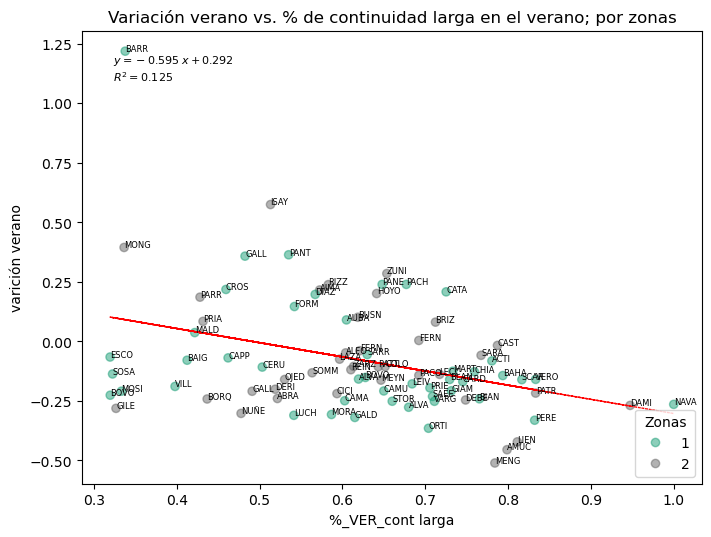

In [89]:
#desactivar opción interactiva
#%matplotlib notebook
%matplotlib inline 


x = por_AC_Sup_region_comp_CP_sin8960['%_VER_cont larga']
y = por_AC_Sup_region_comp_CP_sin8960['var verano']
zona = por_AC_Sup_region_comp_CP_sin8960['Zona']
nombres = por_AC_Sup_region_comp_CP_sin8960['nombre']

figure(figsize=(8, 6), dpi=100)
scatter = plt.scatter(x, y, c=zona, alpha=0.5, cmap='Dark2')

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r:", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=8, verticalalignment='top')
plt.title('Variación verano vs. % de continuidad larga en el verano; por zonas')
plt.xlabel('%_VER_cont larga')
plt.ylabel('varición verano')

# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower right", title="Zonas")

for i, txt in enumerate(nombres):
    plt.annotate(txt, (x[i], y[i]), fontsize=6)

plt.show()